In [1]:
import sys
# import comet_ml
import torch

import numpy as np

from sklearn.metrics import (
    f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, accuracy_score,
)
# from transformers.integrations import CometCallback

sys.path.append('..')
from lib.utils import set_seed, get_device
from lib.utils.constants import RANDOM_SEED
from lib.data.loading import pd_read_jsonl_file

In [2]:
import os
# from dotenv import load_dotenv

# load_dotenv()

# comet_api_key = os.getenv("COMET_API_KEY")

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
import torch

torch.cuda.empty_cache()

In [4]:
set_seed(RANDOM_SEED)

DEVICE = get_device()
print(f'Using device: {DEVICE}')

Using device: cuda


In [5]:
df_en_train = pd_read_jsonl_file('../data/multilingual_train.jsonl')
df_en_dev = pd_read_jsonl_file('../data/multilingual_dev.jsonl')
df_en_test = pd_read_jsonl_file('../data/multilingual_devtest_text_id_only.jsonl')

In [6]:
df_en_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674083 entries, 0 to 674082
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          674083 non-null  object
 1   source      674083 non-null  object
 2   sub_source  674083 non-null  object
 3   lang        674083 non-null  object
 4   model       674083 non-null  object
 5   label       674083 non-null  int64 
 6   text        674083 non-null  object
dtypes: int64(1), object(6)
memory usage: 36.0+ MB


In [7]:
df_en_train.head()

,id,source,sub_source,lang,model,label,text
0,808a846d-41c1-46ff-80ab-892b01bec5f3,m4gt,arxiv,en,gemma-7b-it,1,This report summarizes the findings of the US ...
1,673ec6fc-624a-4ad5-8d5f-a5950b0e5432,mage,wp,en,human,0,I've been standing here for days now. Watching...
2,3059e6e4-1724-4745-a833-cbb6bfb4acd8,mage,xsum,en,flan_t5_xl,1,"Towell, 25, was knocked down twice during the ..."
3,4ca1cde7-6dbd-4519-b60c-7f8c8fcd0d36,hc3,open_qa,zh,gpt-35,1,我不确定你想要问的是什么，但是阿玛尼是一个奢侈品牌，它的产品包括化妆品、香水和时装。黑手党是...
4,f9cca231-ed31-45a9-a448-99245f72e32c,hc3,reddit_eli5,en,gpt-35,1,"Sometimes when we eat certain types of food, o..."


In [9]:
import pandas as pd

# Separate the DataFrame into two based on the label values
df_en_train_label_1 = df_en_train[df_en_train['label'] == 1]
df_en_train_label_0 = df_en_train[df_en_train['label'] == 0]

# Determine the smaller count between the two labels
min_count = min(len(df_en_train_label_1), len(df_en_train_label_0))

# Sample the same number of rows from both DataFrames
df_en_train_label_1_sampled = df_en_train_label_1.sample(n=min_count, random_state=RANDOM_SEED)
df_en_train_label_0_sampled = df_en_train_label_0.sample(n=min_count, random_state=RANDOM_SEED)

# Concatenate the sampled DataFrames to create a new DataFrame with a balanced label distribution
df_en_train = pd.concat([df_en_train_label_1_sampled, df_en_train_label_0_sampled])

# Shuffle the new DataFrame to mix the labels
df_en_train = df_en_train.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

In [10]:
df_en_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515936 entries, 0 to 515935
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          515936 non-null  object
 1   source      515936 non-null  object
 2   sub_source  515936 non-null  object
 3   lang        515936 non-null  object
 4   model       515936 non-null  object
 5   label       515936 non-null  int64 
 6   text        515936 non-null  object
dtypes: int64(1), object(6)
memory usage: 27.6+ MB


In [8]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B"

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Count the number of tokens in each sentence
df_en_train['num_tokens'] = df_en_train['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
df_en_dev['num_tokens'] = df_en_dev['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
df_en_test['num_tokens'] = df_en_test['text'].apply(lambda x: len(tokenizer(x)['input_ids']))

In [ ]:
df_en_train['num_tokens'].describe()

In [ ]:
df_en_dev['num_tokens'].describe()

In [ ]:
df_en_test['num_tokens'].describe()

/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/.conda/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

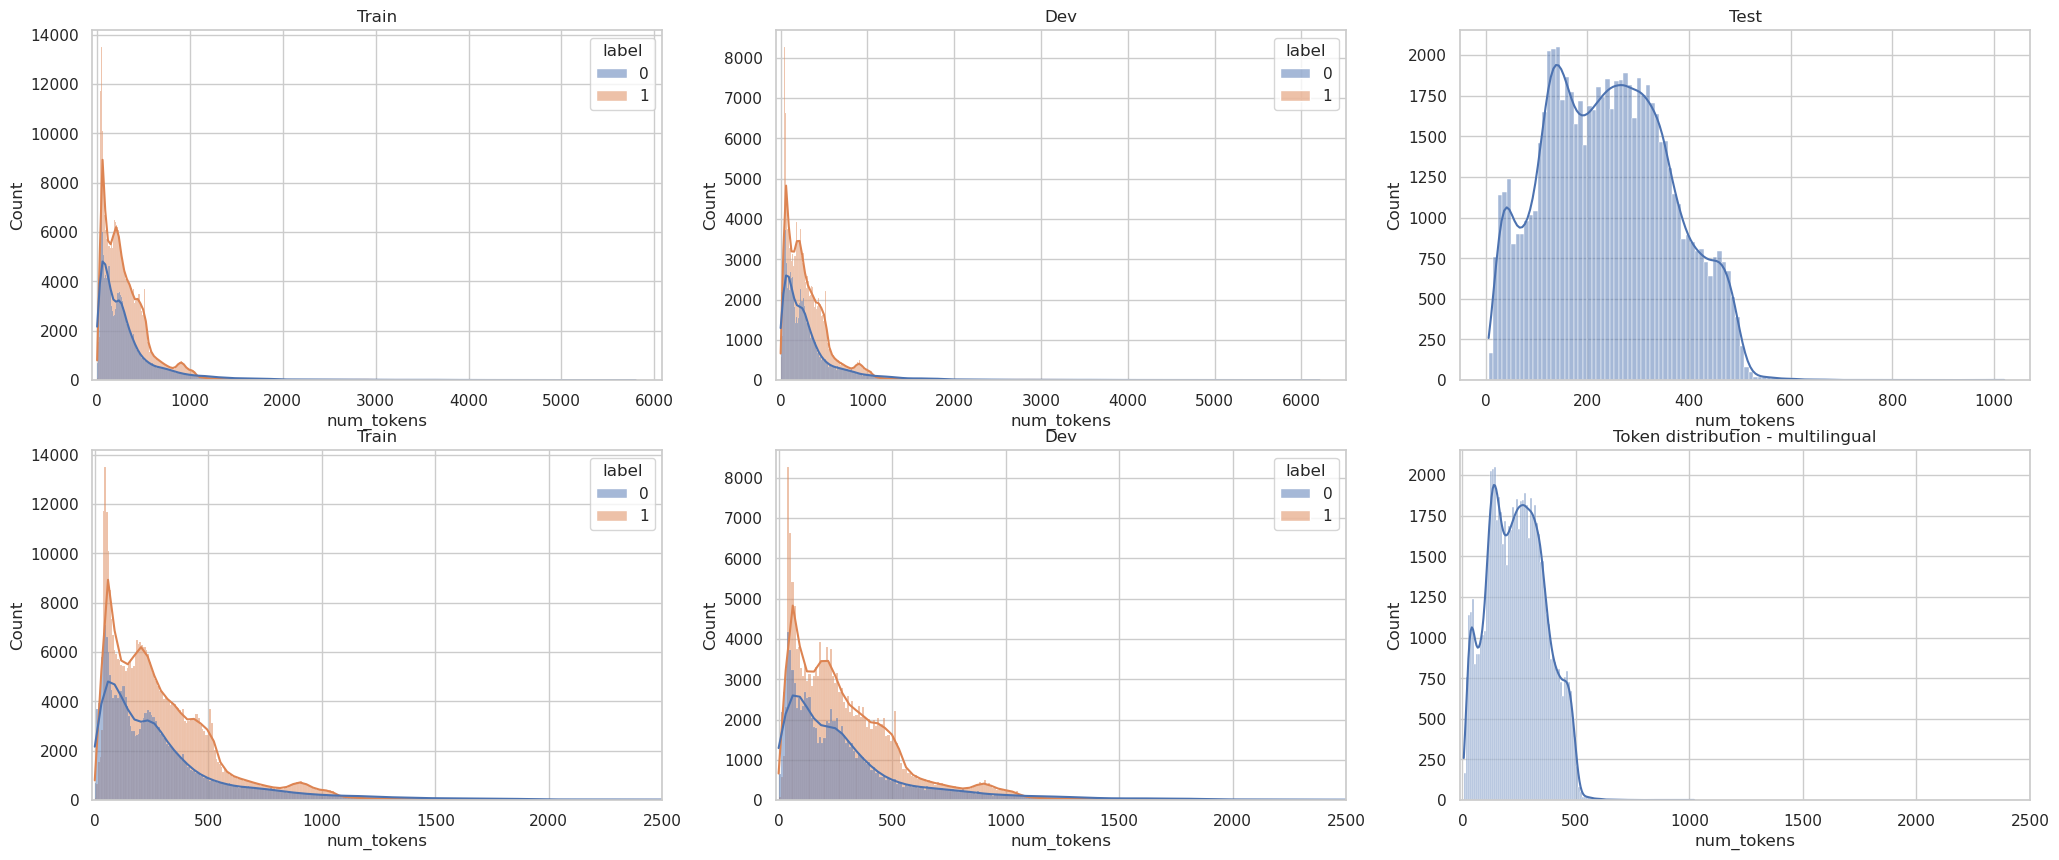

In [16]:
# Create a distribution plot over the number of tokens grouped by dataset and label
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 3, figsize=(25, 10))

sns.histplot(df_en_train, x='num_tokens', hue='label', kde=True, ax=ax[0][0])
sns.histplot(df_en_dev, x='num_tokens', hue='label', kde=True, ax=ax[0][1])
sns.histplot(df_en_test, x='num_tokens', kde=True, ax=ax[0][2])

sns.histplot(df_en_train, x='num_tokens', hue='label', kde=True, ax=ax[1][0])
sns.histplot(df_en_dev, x='num_tokens', hue='label', kde=True, ax=ax[1][1])
sns.histplot(df_en_test, x='num_tokens', kde=True, ax=ax[1][2])

ax[0][0].set_title('Train')
ax[0][0].set_xlim(left=-50)
ax[0][1].set_title('Dev')
ax[0][1].set_xlim(left=-50)
ax[0][2].set_title('Test')
ax[0][2].set_xlim(left=-50)

ax[1][0].set_title('Train')
ax[1][0].set_xlim(left=-10, right=2500)
ax[1][1].set_title('Dev')
ax[1][1].set_xlim(left=-10, right=2500)
ax[1][2].set_title('Test')
ax[1][2].set_xlim(left=-10, right=2500)

plt.title("Token distribution - multilingual")
plt.show()

In [15]:
MODEL_NAME

'Qwen/Qwen2.5-0.5B'

# Load model

In [5]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B"
FINE_TUNED_MODEL_NAME = f"../results/subtask_b/{MODEL_NAME}/001/fine-tuned-model"

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(FINE_TUNED_MODEL_NAME, num_labels=2)

In [13]:
# If a pad_token_id is defined in the configuration,
# it finds the last token that is not a padding token in each row.
# If no pad_token_id is defined, it simply takes the last value in each row of the batch.
model.config.pad_token_id = tokenizer.pad_token_id

In [14]:
model.config.pad_token_id

151643

In [15]:
model

Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): 

In [16]:
for param in model.parameters():
    param.requires_grad = False

for param in model.model.layers[-1].parameters():
    param.requires_grad = True

for param in model.score.parameters():
    param.requires_grad = True

In [17]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

model.layers.23.self_attn.q_proj.weight
model.layers.23.self_attn.q_proj.bias
model.layers.23.self_attn.k_proj.weight
model.layers.23.self_attn.k_proj.bias
model.layers.23.self_attn.v_proj.weight
model.layers.23.self_attn.v_proj.bias
model.layers.23.self_attn.o_proj.weight
model.layers.23.mlp.gate_proj.weight
model.layers.23.mlp.up_proj.weight
model.layers.23.mlp.down_proj.weight
model.layers.23.input_layernorm.weight
model.layers.23.post_attention_layernorm.weight
score.weight


In [18]:
def get_num_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


trainable_params = get_num_parameters(model)
print(f'Trainable parameters: {trainable_params} ({trainable_params / model.num_parameters():.2%})')

Trainable parameters: 14914176 (3.02%)


# Measure performance before training/fine-tuning the model

In [ ]:
import torch

from tqdm import tqdm


def get_performance_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    return {
        'f1': f1,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'confusion_matrix': cm,
        'classification_report': cr
    }


def measure_initial_performance(model, tokenizer, df_test, device, max_length=512, batch_size=64):
    model.to(device)
    model.eval()

    test_samples = df_test.text.tolist()

    outputs = []
    for i in tqdm(range(0, len(test_samples), batch_size)):
        batch = test_samples[i:i + batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            output = model(**inputs)
            outputs.append(output.logits)

    outputs = torch.cat(outputs, dim=0)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

    performance = get_performance_metrics(df_test.label, predictions)
    return performance


initial_performance = measure_initial_performance(model, tokenizer, df_en_dev, DEVICE)
initial_performance

In [11]:
def test_samples(model, tokenizer, df, device, max_length=512):
    model.to(device)
    model.eval()

    test_samples = df.text.tolist()[:5]
    inputs = tokenizer(
        test_samples,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs).logits

    # print(outputs.shape)
    print(outputs)

In [12]:
test_samples(model, tokenizer, df_en_train, DEVICE)

tensor([[-0.0314,  0.0181],
        [-0.0319,  0.0190],
        [-0.0338,  0.0227],
        [-0.0318,  0.0197],
        [-0.0323,  0.0195]], device='cuda:0')


# Fine-tune the model

In [8]:
class_weights = (
    1 / df_en_train.label.value_counts(normalize=True).sort_index()
).tolist()
class_weights = torch.tensor(class_weights)
class_weights = class_weights / class_weights.sum()

class_weights

tensor([0.6173, 0.3827])

In [19]:
from datasets import Dataset, DatasetDict

ds_train = Dataset.from_pandas(df_en_train)
ds_dev = Dataset.from_pandas(df_en_dev)
ds_test = Dataset.from_pandas(df_en_test)

In [20]:
ds_train

Dataset({
    features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
    num_rows: 515936
})

In [21]:
ds_train_shuffled = ds_train.shuffle(seed=RANDOM_SEED)

In [22]:
dataset = DatasetDict({
    'train': ds_train_shuffled,
    'dev': ds_dev,
    'test': ds_test
})

In [23]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 515936
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 288894
    })
    test: Dataset({
        features: ['id', 'lang', 'text'],
        num_rows: 74081
    })
})

In [24]:
MAX_LEN = 2048
# col_to_delete = ['source', 'sub_source', 'lang', 'model']


def preprocess_dataset(ds):
    return tokenizer(ds['text'], truncation=True, max_length=MAX_LEN)


tokenized_datasets = dataset.map(preprocess_dataset, batched=True)
tokenized_datasets.set_format("torch")
     

Map:   0%|          | 0/515936 [00:00<?, ? examples/s]

Map:   0%|          | 0/288894 [00:00<?, ? examples/s]

Map:   0%|          | 0/74081 [00:00<?, ? examples/s]

In [25]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 515936
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 288894
    })
    test: Dataset({
        features: ['id', 'lang', 'text', 'input_ids', 'attention_mask'],
        num_rows: 74081
    })
})

In [26]:
from transformers import DataCollatorWithPadding

collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [27]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'macro_f1': f1_score(predictions, labels, average='macro'),
        'accuracy': accuracy_score(predictions,labels),
        'balanced_accuracy': balanced_accuracy_score(predictions, labels),
    }

In [28]:
import torch
import torch.nn.functional as F

from transformers import Trainer


class WeightedCrossEntropyTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(
                class_weights, dtype=torch.float32
        ).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [31]:
# from comet_ml import Experiment
# from comet_ml.integration.pytorch import log_model

# experiment = Experiment(
#     api_key=comet_api_key,
#     project_name="mgt-detection-coling-2025",
#     workspace="unibuc-phd",
# )

In [29]:
params = {
    "learning_rate": 2e-4,
    "num_train_epochs": 3,
    "weight_decay": 1e-2,
    "batch_size": 32,
    "seed": RANDOM_SEED,
}

# experiment.log_parameters(params)

In [30]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=f"../results/subtask_b/{MODEL_NAME}/002",
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    # report_to="comet_ml",
    seed=params["seed"],
)

comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key


In [31]:
trainer = WeightedCrossEntropyTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['dev'],
    tokenizer=tokenizer,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    # callbacks=[CometCallback()],
)

/tmp/ipykernel_396/3314886341.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(


In [32]:
train_result = trainer.train()

[2024-10-12 22:24:55,481] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Balanced Accuracy
1,0.122300,0.116183,0.949049,0.951418,0.945149
2,0.080200,0.096668,0.961090,0.963049,0.958452
3,0.051200,0.104020,0.965736,0.967448,0.962923


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [33]:
metrics = train_result.metrics
max_train_samples = len(ds_train)
metrics["train_samples"] = min(max_train_samples, len(ds_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =               3.0
  total_flos               =      4220297834GF
  train_loss               =            0.1012
  train_runtime            = 1 day, 7:51:10.55
  train_samples            =            515936
  train_samples_per_second =            13.498
  train_steps_per_second   =             0.422


In [34]:
trainer.save_model(f"../results/subtask_b/{MODEL_NAME}/002/fine-tuned-model")

In [35]:
import pandas as pd
from tqdm import tqdm


def make_predictions(model, tokenizer, df, device, file_path, max_len=MAX_LEN, batch_size=32):
    model.eval()

    all_ids = []
    all_predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(df), batch_size)):
            ids = df[i:i + batch_size].id.tolist()
            texts = df[i:i + batch_size].text.tolist()

            inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
            
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_ids.extend(ids)
            all_predictions.extend(preds)

    df_predictions = pd.DataFrame({
        "id": all_ids,
        "label": all_predictions,
    })

    df_predictions.to_json(
        file_path,
        orient="records",
        lines=True,
    )

    return df_predictions
    

In [ ]:
df_test_predictions = make_predictions(
    trainer.model,
    tokenizer,
    df_en_test,
    DEVICE,
    f"../results/subtask_b/{MODEL_NAME}/002/subtask_b.jsonl",
)

 93%|█████████▎| 2146/2316 [14:59<01:14,  2.27it/s]

In [ ]:
df_en_train.label.value_counts(normalize=True)

In [ ]:
df_test_predictions.label.value_counts(normalize=True)

In [ ]:
import json

with open(f"../results/subtask_b/{MODEL_NAME}/002/config.json", "w") as f:
    json.dump(params, f)

In [40]:
df_en_train

,id,source,sub_source,lang,model,label,text
0,5323a1d0-c3d0-4eb9-b99e-34dfed023ac6,m4gt,arxiv,en,dolly,1,"In this paper, we present a totally secure com..."
1,36e600bf-b7b3-42cb-a19a-c6f77eee01f9,mage,yelp,en,t0_3b,1,My friend and I went here during a destination...
2,a89159dd-b5f3-4724-8f3a-5a4561d300c4,m4gt,peerread,en,davinci,1,This paper presents a novel approach for extra...
3,d83860fd-9ff4-4b19-9de5-33b6c74025bb,hc3,finance,zh,gpt-35,1,要知道还款的具体利息和本金，需要知道贷款的利率、贷款期限、还款方式以及你的还款计划。如果你不...
4,dac67c11-874e-4ca8-8e9f-710429844bb3,m4gt,peerread,en,gpt4,1,"The paper titled ""Learning attention for histo..."
...,...,...,...,...,...,...,...
515931,76910bb6-06f0-431a-9500-3336045c40f2,m4gt,reddit,en,human,0,"First off Russia is not in OPEC, but to answer..."
515932,5209ccc5-3dcd-4516-9520-8b354d8b8178,m4gt,reddit,en,human,0,The Tuskegee Airmen are an interesting group t...
515933,627afa2d-677d-40fc-953d-f19e6b832a7c,mage,xsum,en,opt_30b,1,Inspectors in abattoirs used to be able to cut...
515934,c04010c9-8f4a-4612-8594-30ee18041c91,m4gt,peerread,en,davinci,1,This paper addresses the problem of exploratio...


In [38]:
# experiment.end()

# Test set predictions

In [7]:
MAX_LEN = 2048

In [8]:
model.to(DEVICE)

Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896, padding_idx=151643)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      

In [9]:
import pandas as pd
from tqdm import tqdm


def make_test_set_predictions(model, tokenizer, df, device, file_path, max_len=MAX_LEN, batch_size=32):
    model.eval()

    all_ids = []
    all_predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(df), batch_size)):
            ids = df[i:i + batch_size].testset_id.tolist()
            texts = df[i:i + batch_size].text.tolist()

            inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")

            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_ids.extend(ids)
            all_predictions.extend(preds)

    df_predictions = pd.DataFrame({
#         "id": all_ids,
        "testset_id": all_ids,
        "label": all_predictions,
    })

    df_predictions.to_json(
        file_path,
        orient="records",
        lines=True,
    )

    return df_predictions
    

In [10]:
df_en_test = pd_read_jsonl_file('../data/test_set_multilingual.jsonl')

In [11]:
df_en_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151425 entries, 0 to 151424
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   testset_id  151425 non-null  int64 
 1   text        151425 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
df_test_predictions = make_test_set_predictions(
    model,
    tokenizer,
    df_en_test,
    DEVICE,
    f"../results/subtask_b/{MODEL_NAME}/001/test_set/subtask_b.jsonl",
)

 20%|██        | 949/4733 [32:27<1:56:38,  1.85s/it]

In [ ]:
df_test_predictions.label.value_counts(normalize=True)